# Imports

In [1]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import pickle as pkl

# Load data

In [2]:
df_train = pd.read_csv('data/ready/novelty_detection/train.csv')
print(df_train.shape)
df_train.head(3)

(8517, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [3]:
df_test = pd.read_csv('data/ready/novelty_detection/test.csv')
print(df_test.shape)
df_test.head(3)

(3222, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,11629.0,-3.891192,7.098916,-11.426467,8.607557,-2.065706,-2.985288,-8.138589,2.973928,-6.272790,...,1.757085,-0.189709,-0.508629,-1.189308,1.188536,0.605242,1.881529,0.875260,1.0,1
1,11635.0,0.919137,4.199633,-7.535607,7.426940,1.118215,-2.886722,-1.341036,0.363933,-2.203224,...,0.316094,0.055179,0.210692,-0.417918,-0.911188,0.466524,0.627393,0.157851,1.0,1
2,12093.0,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,...,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,0.0,1


# Prepare data

In [4]:
with open('data/models/novelty_detection/scaler_stats.pkl', 'rb') as handle:
    stats = pkl.load(handle)
    
stats

{'V9': {'mean': 0.7146190771795187, 'std': 1.1408180520740157},
 'V5': {'mean': -0.034014064445657896, 'std': 1.1469934107507669},
 'V25': {'mean': 0.08816896455896987, 'std': 0.422913932767026},
 'V28': {'mean': 0.0012378722056445982, 'std': 0.27084898091255255},
 'V23': {'mean': -0.03642609648668205, 'std': 0.47721176144869615},
 'V15': {'mean': -0.0832484387421991, 'std': 0.9762988869944756},
 'V27': {'mean': 0.009360769856715148, 'std': 0.3969568709147506},
 'V1': {'mean': -0.2603650842925114, 'std': 1.491390025700216},
 'V19': {'mean': -0.05525353643229752, 'std': 0.8024721730721641},
 'V14': {'mean': 0.6405087677843762, 'std': 1.0283090565656978},
 'V7': {'mean': -0.03326239531396446, 'std': 1.0283209938929365},
 'V3': {'mean': 0.9237004737020951, 'std': 1.0265360949372908},
 'V22': {'mean': -0.1568740594384358, 'std': 0.6455801984878736},
 'V10': {'mean': -0.1649298758068517, 'std': 1.025247290830579},
 'V26': {'mean': 0.06246142347345862, 'std': 0.5429930869740929},
 'V17': {'m

In [5]:
for col in stats.keys():
    df_train[col] = (df_train[col] - stats[col]['mean']) / stats[col]['std']
    df_test[col] = (df_test[col] - stats[col]['mean']) / stats[col]['std']

In [6]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,8517.0,4.707722e+03,3535.317169,0.000000,1640.000000,3755.000000,7595.000000,11490.000000
V1,8517.0,3.860296e-16,1.000000,-15.292094,-0.509841,-0.092126,0.940211,1.489122
V2,8517.0,-6.787651e-16,1.000000,-20.697599,-0.393836,0.026434,0.512791,6.378819
V3,8517.0,-5.400152e-15,1.000000,-12.969097,-0.509303,0.019053,0.656683,3.095864
V4,8517.0,-1.089236e-16,1.000000,-3.457387,-0.616987,-0.000502,0.642418,4.711851
V5,8517.0,7.205956e-17,1.000000,-27.949694,-0.527397,-0.080407,0.367250,10.469357
V6,8517.0,-4.150464e-17,1.000000,-5.934704,-0.609145,-0.238144,0.283413,16.330199
V7,8517.0,3.504561e-17,1.000000,-12.579154,-0.477273,0.018276,0.526985,33.390779
V8,8517.0,2.282103e-16,1.000000,-18.078942,-0.094432,0.063166,0.276055,3.033658
V9,8517.0,-6.667986e-16,1.000000,-3.551333,-0.652833,-0.027462,0.611387,8.483623


# Apply model

In [30]:
cols_x = list(stats.keys())

In [67]:
svm = OneClassSVM(nu=0.05)

svm.fit(df_train[cols_x])

OneClassSVM(nu=0.05)

In [68]:
y_test_pred = svm.predict(df_test[cols_x])
y_test_pred[:5]

array([-1, -1, -1, -1, -1])

In [69]:
y_test_pred = pd.Series(y_test_pred)
y_test_pred.value_counts()

 1    2451
-1     771
dtype: int64

In [70]:
y_test_pred.replace(to_replace={1: 0
                               , -1: 1}, inplace=True)

y_test_pred.value_counts()

0    2451
1     771
dtype: int64

In [71]:
acc = accuracy_score(y_test_pred, df_test['Class'])
rec = recall_score(y_test_pred, df_test['Class'])

cm = confusion_matrix(y_test_pred, df_test['Class'])

TEST accuracy = 0.8767846058348852
TEST recall = 0.543450064850843


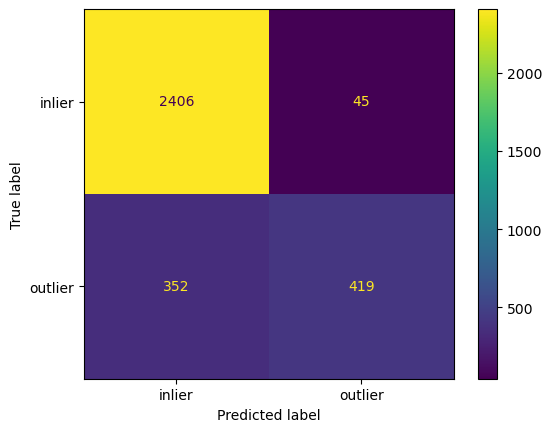

In [72]:
print(f'TEST accuracy = {acc}')
print(f'TEST recall = {rec}')

cm_plot = ConfusionMatrixDisplay(cm, display_labels=['inlier', 'outlier'])

cm_plot.plot()